## Going15 : 사람의 몸짓을 읽어보자

### 15-1 : 들어가며

### Human Pose Estimation with Keypoint detection

기존에 배웠던 얼굴인식 애플리케이션과 다르게 전신이 등장하는 것도 색다른 특징이다. 

스노우와 같은 얼굴인식뿐만 아니라 더 넓은 범위로 사용할 수 있다면 세상에 없던 것을 만들 수 있다.

오늘은 새로운 기능인 `Human pose estimation`에 대한 개념과 이론에 대해 알아보자.

### 15-2 : body language, 몸으로 하는 대화

Human pose estimation(HPE)은 크게 2D와 3D 로 나누어진다.

2D HPE 는 2D 이미지에서 (x, y) 2차원 좌표들을 찾아내고, 3D HPE 는 2D 이미지에서 (x, y, z) 3차원 좌표들을 찾아내는 기술이다.

2차원 이미지에서 3차원 이미지를 복원하는 일은 매우 어려운 일이다.

 - 영상 Geometry #1 좌표계 -> https://darkpgmr.tistory.com/77  
 
 
 - 영상 Geometry #7 Epipolar Geometry -> https://darkpgmr.tistory.com/83?category=460965
 

#### Q. 2차원 이미지에서 3차원 이미지를 복원하는 일이 어려운 이유는 뭘까?

 - (직관적인 예시) 2D 영상에서는 큰 원통이 멀리 있는 것과 작은 원통이 가까이 있는 것을 구분할 수 없습니다.  
 
 
 - (이론적인 설명) 카메라 행렬에서 [x y z] real world 좌표가 이미지 [u v] 좌표계로 표현될 때 z 축(거리 축) 정보가 소실되기 때문입니다.
 

사람의 몸은 3D 환경에서 제약이 있다. 발은 바닥에 있고 무릎은 머리 위로 갈 수 없듯이 말이다. 이런 제약 조건을 이용해 어느정도 문제를 해결할 수 있다.

3D pose estimation을 깊이 다루기엔 오랜 시간이 걸리므로 오늘은 2D 영상 내에서 (x, y) pose (관절)의 위치를 찾는 방법을 다뤄보려 한다.



### 15-3  : Pose 는 face landmark 랑 비슷해요

우리는 이미 2D pose estimation을 다룬 적이 있다. face landmark와 매우 비슷한 면이 있다. 딥러닝이나 사람의 시각에서도 실제로도 매우 비슷한 애플리케이션이다. 입력과 출력이 개수만 다를 뿐 매우 비슷하다. 

하지만 난이도에서 매우 차이가 나는데 face landmark는 물리적으로 거의 고정되어있지만, human pose는 팔, 다리가 상대적으로 넓은 범위와 자유도를 갖는다는 것을 고려해야 한다.

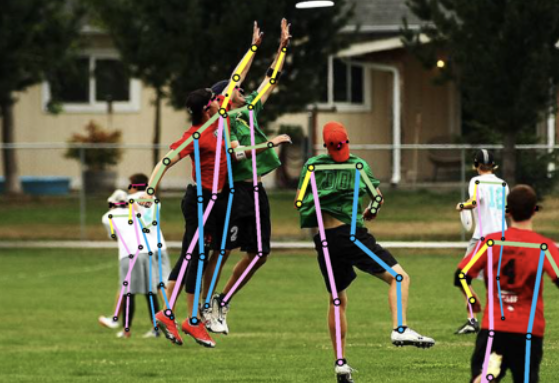

자유도가 높은 것은 데이터 분포를 특정하기 어렵다고 표현할 수 있다. 데이터 분포를 학습하기 어렵다면 당연히 학습에 더 많은 데이터가 필요하고 더 복잡한 모델을 사용해야 한다는 것을 의미한다.

따라서 상당히 많은 사전 작업이 요구되고 사용하려는 애플리케이션에 따라 접근 방법도 달라진다.

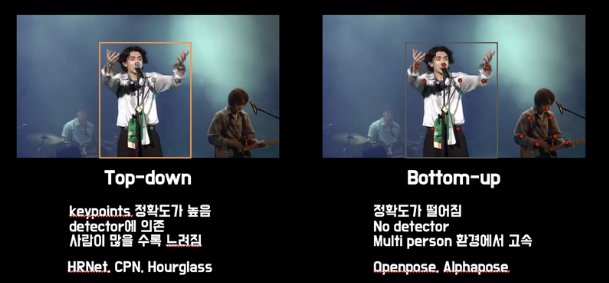

첫번째 방법은 `Top-down` 방법이다.

 - 모든 사람의 정확한 keypoint를 찾기 위해 object detection을 사용한다.  
 
 
 - crop 한 이미지 내에서 keypoint를 찾아내는 방법으로 표현한다.  
 
 
 - detector가 선행되어야 하고 모든 사람마다 알고리즘을 적용해야 하기 때문에 사람이 많이 등장할 때는 느리다는 단점이 있다.
 
 
두번째 방법은 `Bottom-up` 방법이다.

 - detector가 없고 `keypoint를 먼저 검출`한다. 예를 들어 손목에 해당하는 모든 점들을 검출한다.  
 
 
 - 한 사람에 해당하는 keypoint를 clustering한다.  
 
 
 - detector가 없기 때문에 다수의 사람이 영상에 등장하더라도 속도 저하가 크지 않다. 반면 top down 방식에 비해 keypoint 검출 범위가 넓어 성능이 떨어진다는 단점이 있다.
 
 
얼마나 정확해야 하는지, 여러 사람이 등장하는지에 따라 필요한 알고리즘이 달라질 수 있다. 핸드폰 카메라로 찍는 인물들은 대체로 소수로 등장하기 때문에 top-down 방식을 사용해요 큰 속도 저하 없이 사용할 수 있을 것이라 생각한다.

그렇기 때문에 Top-down 방법들에 대해 자세히 알아본다.

### 15-4 : human keypoint detection (1)

### 자유도가 높은 사람의 동작

human pose estimation은 keypoint의 localization 문제를 푼다는 점에서 비슷하다. 하지만 손목, 팔꿈치 등의 joint keypoint 정보는 얼굴의 keypoint보다 훨씬 다양한 위치와 변화를 보인다.

손이 얼굴을 가리는 행위, 모든 keypoint가 영상에 담기지 않는 등 invisible, occlusions, clothing, lighting change가 face landmark에 비해 더 어려운 환경을 만들어낸다.

딥러닝 기반 방법이 적용되기 전에는 다양한 사전 지식이 사용되었다.

가장 기본이 되는 아이디어는 `인체는 변형 가능 부분으로 나누어져 있고 각 부분끼리 연결성을 가지고 있다.`는 것이다.

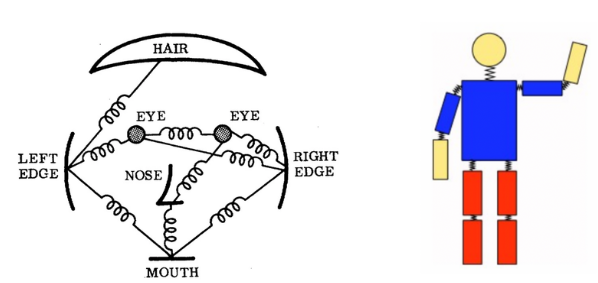

https://nanonets.com/blog/human-pose-estimation-2d-guide/

그림에서 보듯이 손은 팔, 팔은 몸과 연결되어 있다. 손이 다리 옆에 있을 확률이 팔 옆에 있을 확률보다 훨씬 작을 것이다. 이런 제약 조건을 그림에 보이는 스프링으로 표현했다.

3D 환경에서 생각하면 정말 좋은 방법이다. 하지만 우리가 다루는 데이터는 2D 이미지 데이터이기 때문에 촬영 각도에 따라 충분히 팔이 다리 옆에서 관찰될 수 있다.

이 문제를 해결하기 위해 Deformable part models 방법에서는 각 부분(part)들의 complex joint relationship의 mixture model로 keypoint를 표현하는 방법을 이용했지만 성능은 사람들의 기대에 미치지 못했다. 자세한 내용은 아래 논문을 참고하자.

https://www.cs.cmu.edu/~deva/papers/pose_pami.pdf


### DeepPose

딥러닝 이전의 전통적 pose estimation 모델은 분명한 한계가 있었다. deformable parts model 논문에서 언급했듯이 graphical tree model과 같은 이미지에 두번 연산을 하는 등 연산 효율이 떨어지는 점과 그와 비해서도 부족한 성능이 문제점으로 인식되어 왔다.

AlexNet 이후, 다양한 분야에 CNN이 적용되며, pose estimation 분야에도 CNN을 이용한 방법이 나타나기 시작했다. Toshev and Szegedy는 처음으로 딥러닝 기반 keypoint localization 모델을 제안했다.


DeepPose: Human Pose Estimation via Deep Neural Networks - https://arxiv.org/pdf/1312.4659.pdf


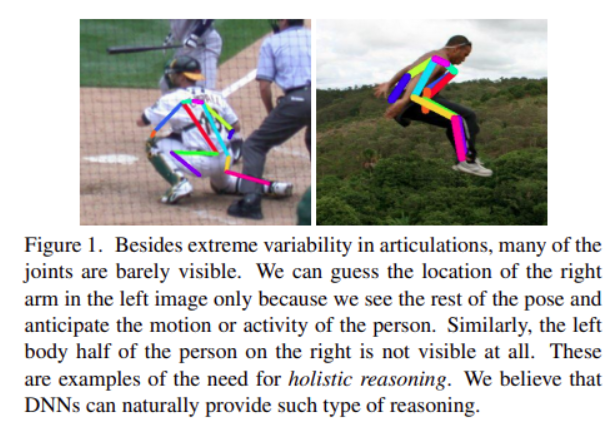


기존 기술로는 풀기 어려웠던 동작의 다양성, invisible joint 의 문제를 언급하며 딥러닝 기반 추론 방법이 해결책이 될 수 있다는 것을 증명 해냈다. 


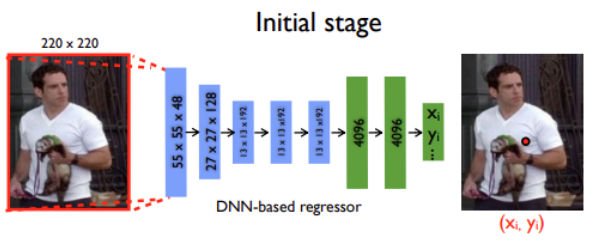


초기의 pose estimation 모델은 x,y 좌표를 직접적으로 예측하는 position regression 문제로 인식했다. human detection 을 통한 crop 된 사람 이미지를 이용해서 딥러닝 모델에 입력하고 (x,y) 좌표를 출력하도록 만든다.


DeepPose는 매우 혁신적인 시도였던 것에 비해 사실 성능이 압도적으로 높았던 것은 아니다.

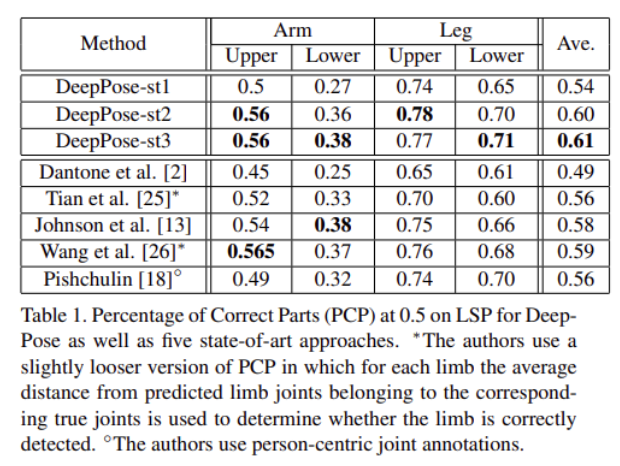

표에서 볼 수 있듯이 DeepPose 가 전반적으로 높은 성능을 나타내고 있긴 하지만 기존 Tree based model 인 Wang et al. 의 방법에 비해 비약적으로 성능을 상승시켰다고 말하기는 어렵다. DeepPose 의 기여는 `SOTA에 가까운 성능을 내면서도 딥러닝을 적용한 첫 번째 사례`라고 할 수 있다.


### Efficient Object Localization Using Convolutional Network

DeepPose는 딥러닝을 사용했는데 왜 성능이 비약적으로 상승하지 않았을까? 이 논문이 해결책을 제시하고 있다.

Tompson이 제안한 Efficient object localization 방법을 간단히 소개한다.

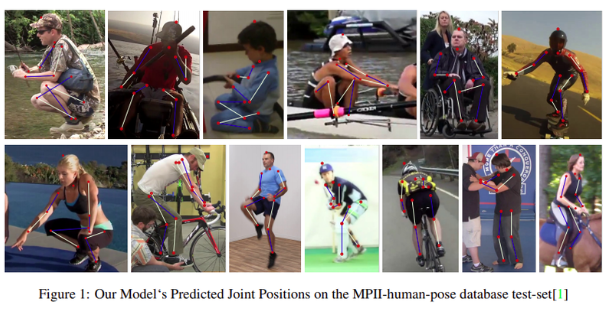


이 논문에서는 제안했던 모델도 DeepPose 에 비해 깊어졌지만, 가장 중요한 건 keypoint의 위치를 직접 예측하기보다 `keypoint가 존재할 확률 분포를 학습하게 하자`는 점이다.

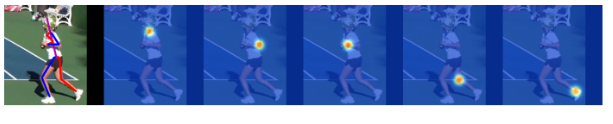

https://nanonets.com/blog/human-pose-estimation-2d-guide/


human pose (keypoint) 도 사람이 labeling 을 할 수밖에 없는데 사람이 항상 같은 위치의 점을 찍을 수 있을까? 동영상으로 보면 조금 더 쉽게 관찰할 수 있다. 

https://github.com/Team-Neighborhood/Kalman-Filter-Image

Kalman filter 라고 적힌 동영상에 비해 Orig measured 는 점이 굉장히 떨리고 있다는 사실을 알 수 있다. 항상 같은 위치라고 생각하며 keypoint를 선택하지만 사실 매 사진마다 수 픽셀씩 차이가 생기게 된다. 눈을 찍고 싶다면 눈을 중심으로 `어떤 분포`의 에러가 더해져 저장되는 것이다.

자연상태에서 일어나는 확률 분포는 가우시안 분포일 가능성이 크다. Tompson 은 이런 점에 착안하여 label 을 (x,y) 좌표에서 (x,y) 를 중심으로 하는 heatmap 으로 변환했다. 딥러닝 모델은 이 heatmap 을 학습하게 되는 것이다. 

`"keypoint 가 존재할 확률"을 학습하게 된 이후로 성능이 비약적으로 향상`되는 모습을 볼 수 있다. 

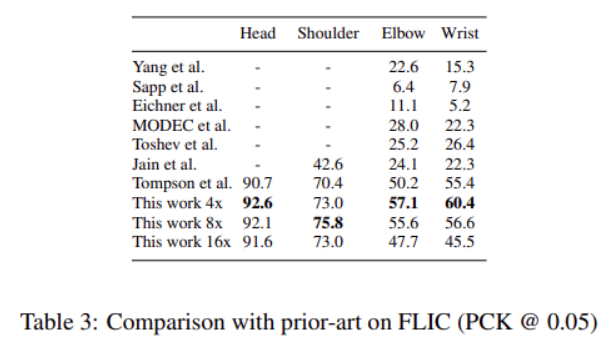

Toshev가 제안한 DeepPose 에 비해 무려 2배가 넘는 수치를 볼 수 있다. 머리의 경우 0.9가 넘는 높은 성능을 가지게 되었다.

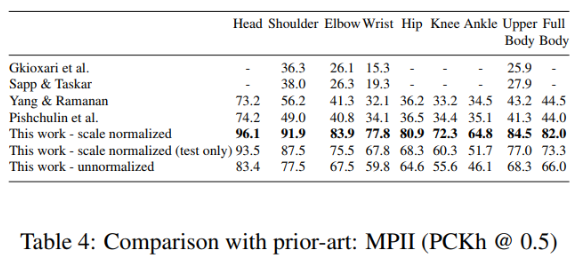


MPII 데이터는 2014년에 나온 데이터이다. 기존 FLIC 데이터가 머리, 어깨, 팔꿈치, 손목 수준의 적은 개수의 keypoint를 가지고 있었지만 MPII는 몸의 각 관절 부위 16개의 keypoint를 갖는다.

기존 논문 (Gkioxari, Sapp) 들이 일부 데이터가 없는 이유이다.

Tompson이 제안한 방법은 heatmamp 학습 뿐만이 아니고 모델에서도 개선을 이뤘는데, 어떤 방법이 있는지 자세한 내용은논문에서 확인해보자.

https://arxiv.org/pdf/1411.4280.pdf


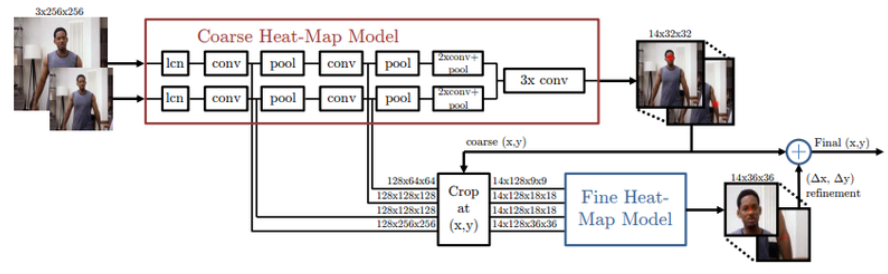


#### Q. Tompson이 제안한 모델은 Coarse model 과 fine model 로 나누어집니다. 두 모델 간에 어떤 관계가 있을까요? 위 그림을 참고해 설명해 봅시다.

 - coarse model 에서 32x32 heatmap 을 대략적으로 추출한 후 multi resolution 입력을 coarse heatmap 기준으로 crop 한 뒤 fine model 에서 refinement 를 수행합니다.
 
 
#### Q. Tompson 이 제안한 모델에서 weight sharing 이 적용된 부분을 설명해 봅시다. 왜 그렇게 만들었을까요?

 - coarse model 과 fine model 이 같은 모델이며 weight 를 공유합니다. 목적이 같기 때문에 빠른 학습이 가능하고 메모리, 저장공간을 효율적으로 사용할 수 있습니다.


### 15-5 : human keypoint detection (2)

### Convolutional Pose Machines

CVPR 2016에서 발표된 CPM 은 completely differentiable 한 multi-stage 구조를 제안했다.  multi stage 방법들은 DeepPose 에서부터 지속적으로 사용되어 왔었다. 

하지만 crop 연산 등 비연속적인 미분 불가능한 stage 단위로 나눠져 있었기 때문에 학습 과정을 여러 번 반복하는 비효율적인 방법을 사용해왔었다.

https://arxiv.org/pdf/1602.00134.pdf

CPM 은 end-to-end 로 학습할 수 있는 모델을 제안한다.

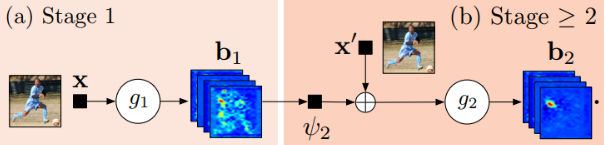

Stage 1 은 image feature 를 계산하는 역할을 하고 stage 2는 keypoint 를 예측하는 역할을 한다. g1과 g2 모두 heatmap 을 출력하게 만들어서 재사용이 가능한 부분은 weight sharing 할 수 있도록 세부 모델을 설계했다.

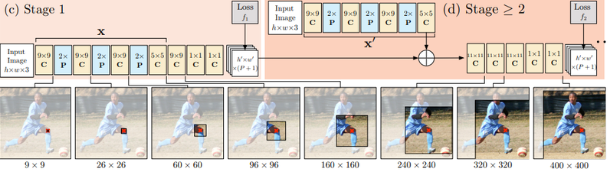

Stage ≥ 2 에서 볼 수 있듯이 stage 2 이상부터는 반복적으로 사용할 수 있다. 보통은 3개의 스테이지를 사용한다고 한다. stage 1 구조는 고정이고 stage 2 부터는 stage 2 구조를 반복해서 추론한다.

stage 2 부터는 입력이 heatmap(image feature)이 되기 때문에 stage 단계를 거칠수록 keypoint가 refinement 되는 효과를 볼 수 있다.


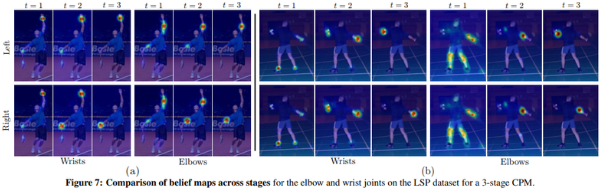


하지만 CPM 이 아주 좋은 방법이라고는 말하기 어렵다. Multi-stage 방법을 사용하기 때문에 end-to-end 로 학습이 가능하더라도 그대로 학습하는 경우는 높은 성능을 달성하기 어렵다. 따라서 stage 단위로 pretraining 을 한 후 다시 하나의 모델로 합쳐서 학습을 한다.

논문을 작성하기 위해서라면 충분히 감내할 수 있지만 서비스 측면에서 바라본다면 불편한 요소라고 할 수 있다. 이런 문제점들은 후에 제안되는 모델들이 적극적으로 개선하고 있다.

CPM 을 다루는 이유는 성능 때문인데, receptive field를 넓게 만드는 multi stage refinement 방법이 성능 향상에 크게 기여한 것 같다.

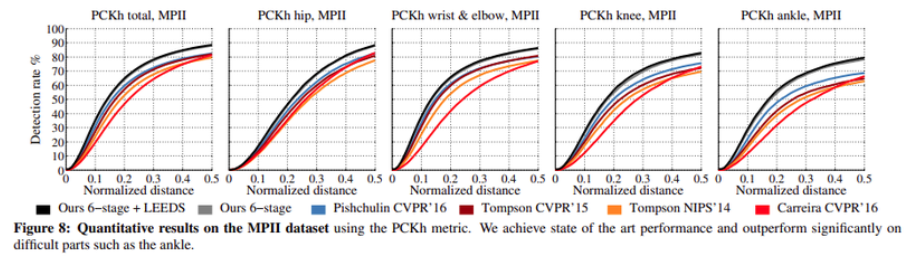

주황색 실선이 Tompson 알고리즘이다. CPM 에서 제안한 검정색, 회색 실선이 detection rate에서 유의미한 차이를 보이고 있는 것을 볼 수 있다. MPII 의 PCKh@0.5 에서 87.95% 를 달성했다고 한다. 당시 2등보다 6.11%p 높은 성능을 보였다.

### Stacked Hourglass Network

ECCV16 에서는 DeepPose 이후 랜드마크라고 불릴만한 논문이 제안되었다. 

https://arxiv.org/pdf/1603.06937.pdf

### Hourglass

`Stacked Hourglass Network`의 기본 구조는 모래시계 같은 모양으로 만들어져 있다. Conv layer와 pooling으로 이미지 (또는 feature)를 인코딩하고 upsampling layer 를 통해 feature map 의 크기를 키우는 방향으로 decoding한다. feature map 크기가 작아졌다 커지는 구조여서 hourglass 라고 표현한다.

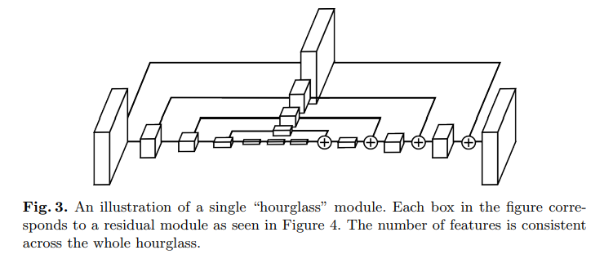

기존 방법들과의 가장 큰 차이점은

 1. feature map upsampling  
 
 
 2. residual connection
 
이라고 할 수 있다.

pooling으로 image의 global feature를 찾고 upsampling으로 local feature를 고려하는 아이디어가 hourglass의 핵심 novelty라고 할 수 있다. 

resnet을 복습해 보기 바란다.

https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/He_Deep_Residual_Learning_CVPR_2016_paper.pdf


hourglass의 모델 구조를 보면 U-Net과 비슷하다. 

 - U-Net -> https://arxiv.org/abs/1505.04597
 
 
Hourglass는 이 간단한 구조를 여러 층으로 쌓아올려서 (stacked) human pose estimation의 성능을 향상시켰다.

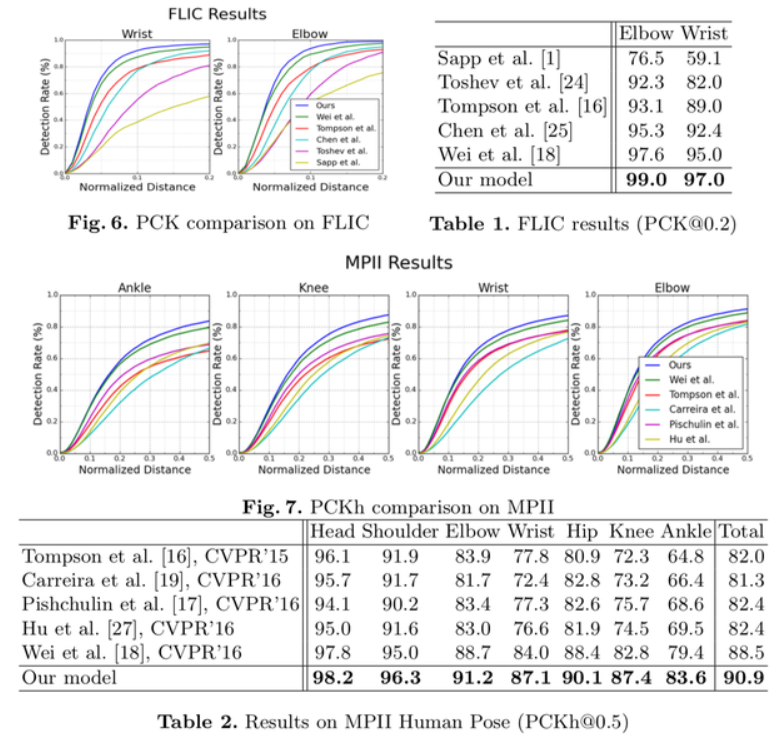

MPII 에서 처음으로 PCKh@0.5 기준 90%를 넘어서는 성과를 보이게 된다. 특유의 간단한 구조와 높은 성능으로 현재까지도 많이 사용되고 있는 구조이다. human pose 분야에 관심이 있으시다면 한 번 사용해 보시기를 권장한다.


### SimpleBaseline

앞서 소개해드린 연구들은 딥러닝 기반의 2D human pose estimation 이 어떻게 발전해 왔는지 보여주고 있다. 

(x, y) 를 직접 regression 하는 방법이 heatmap 기반으로 바뀌고 모델의 구조가 바뀌어 가면서 encoder-decoder 가 쌓아져 가는 형태가 완성되었다. 

결과적으로 MPII 에서 90% 를 넘길 정도로 좋아졌지만 모델의 구조는 다소 복잡해졌다. 

HPE 의 연구를 쭉 따라오던 당시 Microsoft 인턴 Haiping Wu는 약간 다른 시각을 가졌다.

`"기술 자체가 많이 발전했는데 현재의 간단한 모델은 얼마나 성능이 좋을까?"`

SimpleBaseline의 저자는 정말 아주 간단한 encoder-decoder 구조를 설계한다.

 - SimpleBaseline -> https://arxiv.org/pdf/1804.06208.pdf
 
 
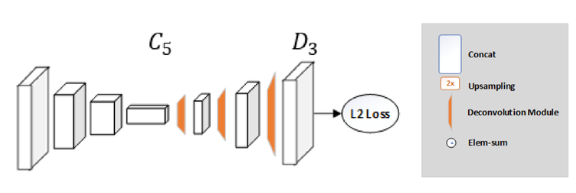

그리고 이 구조로 무려 '73.7%'의 AP 를 COCO 에서 달성한다. 직전 연도(2017년) 의 72.1% 결과를 뛰어넘는 수치이다. 인턴 성과로 ECCV'18에 출판되는 위엄을 보여주었다.

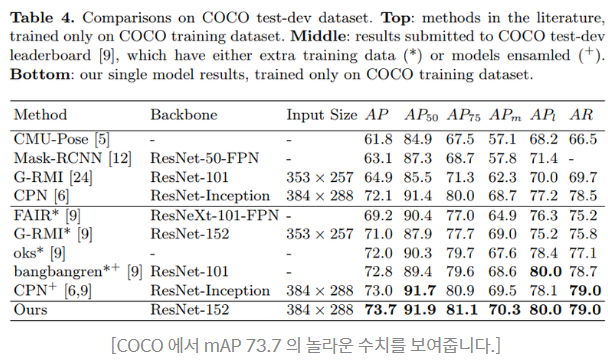

직전 방법인 hourglass 와 직접 비교해 보면, 아래와 같은 결과가 나온다고 한다.

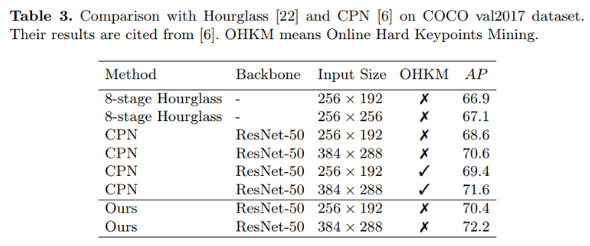

resnet 50 만 사용한 간단한 구조가 hourglass 와 같은 SOTA(state-of-the-art) 를 이겼다는 것에 큰 놀라움을 선물한 논문이라고 생각한다.

고로 `CPN` 은 이전에 소개한 Convolutional Pose Machine 이 아닌 `Cascaded Pyramid Network` 라는 모델이다. 자세히 소개 드리지는 않지만 skip connection 이 stage 사이에 연결되어 있다는 정도로 이해하고 넘어가시면 좋다.

SimpleBaseline은 구조가 간단하기 때문에 다뤄보기 좋을 것이다.

### Deep High-Resolution Network (HRNet)

- HRNet -> https://arxiv.org/pdf/1902.09212.pdf

HRNet 은 개발된 이후 현재까지도 SOTA 에 가까운 성능을 보일 정도로 성능이 좋은 알고리즘이다. Simplebaseline의 1저자가 참여해 연구한 모델이기 때문에 Simplebaseline과 같은 철학을 공유한다.

Stacked hourglass, Casecaded pyramid network 등은 multi-stage 구조로 이루어져 있어서 학습 & 추론 속도가 느리다는 큰 단점이 있다. (대신 하이퍼파라미터를 최적화할 경우 1-stage 방법보다 성능이 좋다.)

반면 Simplebaseline 과 HRNet은 간단함을 추구하는 만큼 1-stage 를 고수하기 때문에 구조도 간결해지고 사용하기도 쉽다는 장점이 있다.

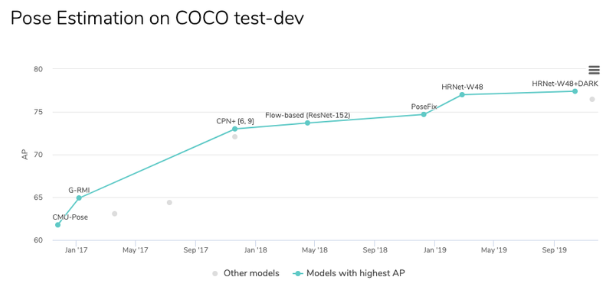

https://paperswithcode.com/sota/pose-estimation-on-coco-test-dev

COCO 데이터셋에서 한때 SOTA 의 성능을 자랑했다.

1-stage 에서 어떻게 모델을 변화 시켰을지 기존 알고리즘들을 먼저 살펴본다.

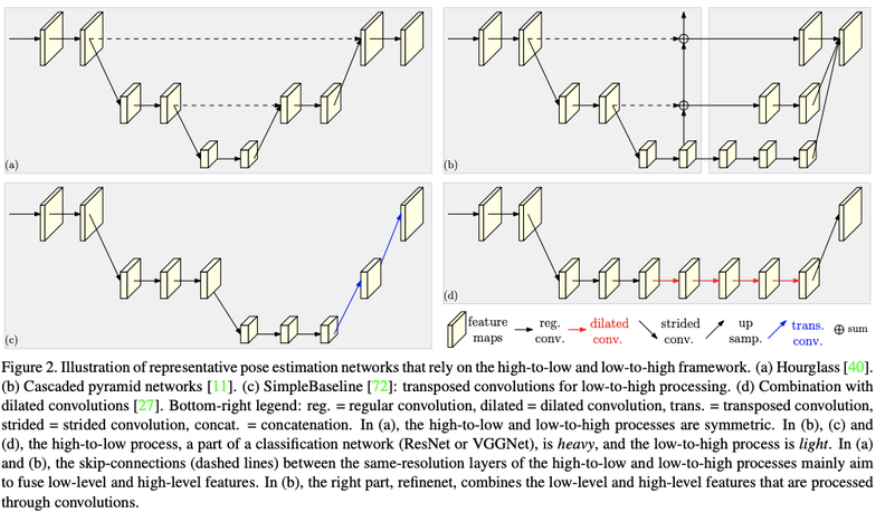

(a) : Hourglass <br/>
(b) : CPN(cascaded pyramid networks) <br/>
(c) : SimpleBaseline - transposed conv <br/>
(d) : SimpleBaseline - dilated conv


#### Q. 위 그림에서 Simplebaseline 이 다른 알고리즘들에 비해 성능이 떨어지지 않지만 구조를 보면 공통점과 차이점을 관찰할 수 있습니다. 어떤 공통점과 차이점이 있을까요?

 - 공통점 : high resolution → low resolution 인 encoder 와 low → high 인 decoder 구조로 이루어진 점  
 

 - 차이점 : Hourglass 는 encoder 와 decoder 의 비율이 거의 비슷함(대칭적임). 반면 Simplebaseline 은 encoder 가 무겁고 (resnet50 등 backbone 사용) decoder 는 가벼운 모델을 사용함. (a), (b) 는 skip connection 이 있지만 (c) 는 skip connection 이 없다.
 
 
#### Q. 차이점에 조금 더 집중해보면 기존 모델들은 skip connection 을 적극적으로 사용했습니다. 왜 사용했을까요? Simplebaseline 도 사용해야하지 않을까요? 동료들과 의논해 봅시다.

 - pooling(strided conv) 할 때 소실되는 정보를 high level layer에서 사용해서 detail한 정보를 학습하기 위해 사용합니다. 당연히 사용할 때 성능이 더 좋을 것 같습니다.
 

HRNet 저자도 앞의 질문들에 대해 고민을 했다. high → low → high 의 구조에서 high resolution 정보(representation)을 유지할 수 있는 모델을 어떻게 만들 수 있을까?


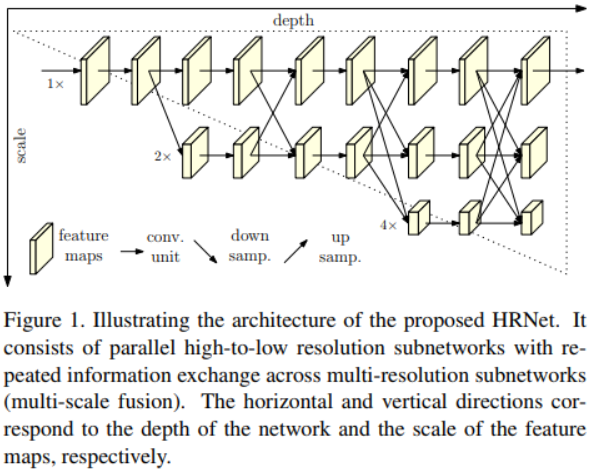


고민의 결과, down sample layer를 만들고 작아진 layer feature 정보를 다시 upsampling해서 원본 해상도 크기에 적용하는 모델을 제안했다. 다소 복잡해 보이지만 1-stage로 동작하기 때문에 전체 flow를 보면 엄청 간단하다. 

우리가 앞에서 다뤘던 CPM이나 Hourglass는 중간 단계에서의 heatmap supervision이 학습과정에 꼭 필요했는데 HRNet 은 필요가 없기 때문이다.

구현도 Simplebaseline의 backbone인 Resnet을 HRNet으로 교체만 해주면 되기 때문에 사용하기도 굉장히 편리하다. 

HRNet 또한 이전 알고리즘 들과 마찬가지로 heatmap을 regression하는 방식으로 학습하고 MSE loss를 이용한다. (특히 Simplebaseline 과 거의 유사하다.)

결과를 살펴보자.

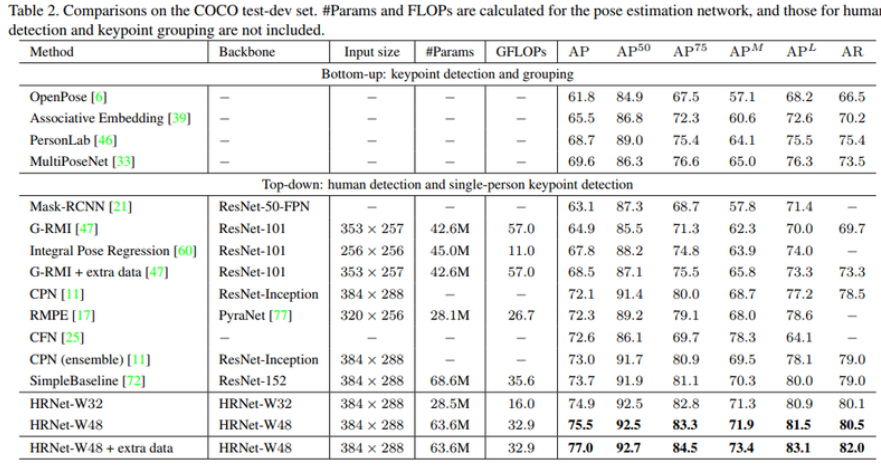

앞에서 다뤘던 Simplebaseline 이 보이고 잠깐 언급된 CPN도 보인다. AP 성능을 보면 HRNet이 4%에 가까운 비약적인 성능 향상을 이뤄냈다.

비교적 학습이 간단하면서 성능까지 좋은 모델이어서 현재도 많이 사용되고 있다. 특히 원저자의 PyTorch 코드가 매우 깔끔하게 구현되어 있고 재생산성이 높아 사용하기 좋다.

https://github.com/leoxiaobin/deep-high-resolution-net.pytorch

### 15-6 : 코드로 이해하는 pose estimation

6개 모델 중 가장 간단한 모델인 SimpleBaseline을 모델 부분만 정확하게 이해해 본다.

### SimpleBaseline 구조

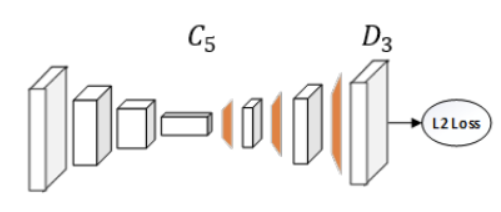

그림을 통해

 - encoder : conv layers  
 
 
 - decoder : deconv module + upsampling
 
 
로 이루어져 있다는 것을 알 수 있지만 conv layer 가 정확히 어떻게 이루어져 있는지, deconv module 은 구성이 어떻게 되어 있는지, deconv module 이 그림처럼 3개일지는 논문을 정확하게 읽어봐야 알 수 있다.

논문 : https://arxiv.org/pdf/1804.06208.pdf


#### Q. conv model 로 어떤 backbone 을 사용하나요?

 - resnet
 
#### Q. deconv module 은 어떤 레이어로 이루어져 있나요?

 - deconv-bn-relu 이 단계가 3개로 이루어져 있습니다. deconv 는 256 filter size, 4x4 kernel, stride 2 로 2배씩 feature map이 커집니다.  
 
 
#### Q. 마지막 출력 레이어는 어떤 레이어로 구성되나요?

 - k 개의 1x1 conv layer로 구성됩니다.
 
 
### PyTorch code 읽어보기

인공지능 분야의 최대 장점은 저자의 공식 코드가 제공된다는 점이라고 할 수 있다. simplebaseline 의 저자도 논문에서 코드 repo 의 위치를 언급했다. 

해당 위치로 들어가면 더 자세히 살펴볼 수 있다. 

 - https://github.com/Microsoft/human-pose-estimation.pytorch
 
 
18년 이후 PyTorch 의 급격한 성장으로 절반 이상의 오픈소스가 파이토치로 공개되고 있다. 

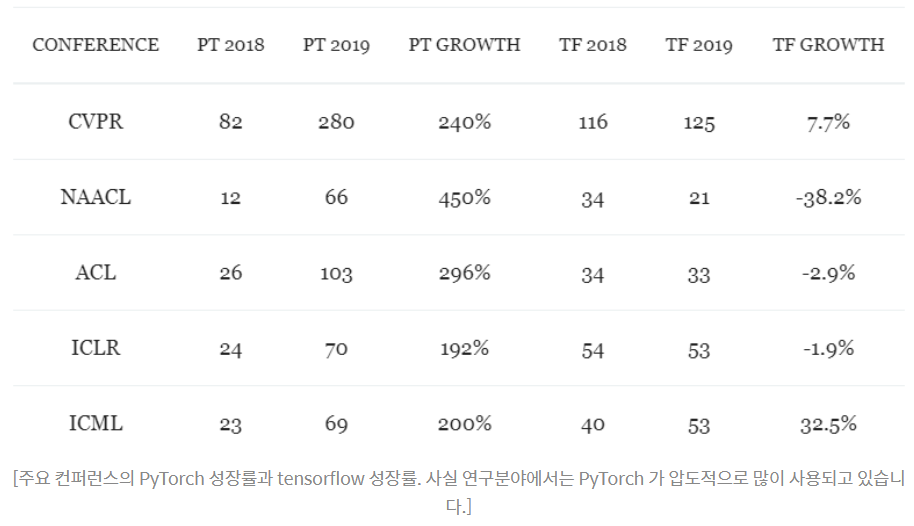

아니나 다를까, 오늘 검토해 보아야 할 공식 코드repo도 파이토치 기반으로 작성되어 있다.

파이토치 코드를 읽을 줄 모른다면 그만큼 참고할 수 있는 코드가 줄어든다는 뜻이다.

이번 스텝만으로 파이토치 코드를 구현할 수 없더라도 지금까지 쌓아온 기본기를 이용해서 simplebaseline 의 파이토치 코드를 같이 읽어보기만 한다.

모델 부분 : https://github.com/microsoft/human-pose-estimation.pytorch/blob/master/lib/models/pose_resnet.py

`nn.` 표현이 많이 등장합니다. `torch.nn` 으로 `keras.layers` 와 같이 딥러닝 모델 구성에 필요한 도구들이 정의되어 있다.

 - https://github.com/microsoft/human-pose-estimation.pytorch/blob/master/lib/models/pose_resnet.py#L29
 

29번째 줄에서는 BasicBlock 이라는 클래스가 보이는데, keras.models로 model을 선언하는 것과 비슷하다.

참고로 pytorch model 에서는 사용된 layer 를 forward 함수를 통해 computational graph 를 그려준다.

 - https://github.com/microsoft/human-pose-estimation.pytorch/blob/master/lib/models/pose_resnet.py#L42
 
 
forward 함수를 읽어보자.

```
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)
```


residual block을 사용한 것을 볼 수 있다.

  - https://github.com/microsoft/human-pose-estimation.pytorch/blob/master/lib/models/pose_resnet.py#L157
  
  
Pose 메인 model 을 살펴보니 4개의 residual block 을 이용합니다. 완전 resnet 과 동일하다.

 - https://github.com/microsoft/human-pose-estimation.pytorch/blob/master/lib/models/pose_resnet.py#L234
 
 
forward 함수를 보면 흐름을 쉽게 알 수 있다.

```
def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.deconv_layers(x)
        x = self.final_layer(x)

        return x
```

resnet 을 통과한 후 `deconv_layers` 와 `final_layer`를 차례로 통과한다.

deconv layer를 찾아보자.

 - https://github.com/microsoft/human-pose-estimation.pytorch/blob/master/lib/models/pose_resnet.py#L219
 
 
```
        layers.append(
                nn.ConvTranspose2d(
                    in_channels=self.inplanes,
                    out_channels=planes,
                    kernel_size=kernel,
                    stride=2,
                    padding=padding,
                    output_padding=output_padding,
                    bias=self.deconv_with_bias))
            layers.append(nn.BatchNorm2d(planes, momentum=BN_MOMENTUM))
            layers.append(nn.ReLU(inplace=True))
```

transpose conv 와 bn, relu 로 이루어져 있는 것을 확인했다.

세세한 파라미터는 어디에 있을까 ? EXTRA 가 자주 등장하는 것을 볼 때, 어떤 configuration 파일이 있을 것으로 짐작해 볼 수 있겠다. repo 내에서 검색해 보면 파라미터 관련 정보를 담고 있는 아래 파일을 찾을 수 있다.

 - https://github.com/microsoft/human-pose-estimation.pytorch/blob/master/experiments/coco/resnet50/256x192_d256x3_adam_lr1e-3.yaml#L23
 
 
```
NUM_DECONV_LAYERS: 3
    NUM_DECONV_FILTERS:
    - 256
    - 256
    - 256
    NUM_DECONV_KERNELS:
    - 4
    - 4
    - 4
```

deconv layer 의 파라미터가 아주 상세히 적혀있다.

이렇게 simplebaseline 의 모델을 상세하게 파악해 볼 수 있었다. 입출력 크기도 계산할 수 있다.

#### Q. 192x256 의 이미지가 입력될 때 출력의 크기는 얼마인가요?

 - resnet 출력이 6x8 이 나오고 3개의 deconv layer 를 통과하므로 48x64 가 출력됩니다.
 
 
파이토치 코드는 케라스 보다 직관적으로 표현되어 있기 때문에 지금처럼 빠르게 파악할 수 있는 장점이 있다.

이제 파악한 지식을 이용해서 tf-simplebaseline 모델을 만들어본다.


### SimpleBaseline - tf2

In [1]:
import os

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

resnet = tf.keras.applications.resnet.ResNet50(include_top=False, weights='imagenet')

deconv module을 만들어주세요.

In [2]:
upconv1 = tf.keras.layers.Conv2DTranspose(256, kernel_size=(4,4), strides=(2,2), padding='same')
bn1 = tf.keras.layers.BatchNormalization()
relu1 = tf.keras.layers.ReLU()
upconv2 = tf.keras.layers.Conv2DTranspose(256, kernel_size=(4,4), strides=(2,2), padding='same')
bn2 = tf.keras.layers.BatchNormalization()
relu2 = tf.keras.layers.ReLU()
upconv3 = tf.keras.layers.Conv2DTranspose(256, kernel_size=(4,4), strides=(2,2), padding='same')
bn3 = tf.keras.layers.BatchNormalization()
relu3 = tf.keras.layers.ReLU()

deconv module에서 중복을 제거할 수 없는지 코드로 표현해보자.

In [3]:
def _make_deconv_layer(num_deconv_layers):
    seq_model = tf.keras.models.Sequential()
    for i in range(num_deconv_layers):
        seq_model.add(tf.keras.layers.Conv2DTranspose(256, kernel_size=(4,4), strides=(2,2), padding='same'))
        seq_model.add(tf.keras.layers.BatchNormalization())
        seq_model.add(tf.keras.layers.ReLU())
    return seq_model

upconv = _make_deconv_layer(3)

In [4]:
final_layer = tf.keras.layers.Conv2D(17, kernel_size=(1,1), padding='same')

각각의 요소를 합쳐 모델을 완성한다.

In [5]:
inputs = keras.Input(shape=(256, 192, 3))
x = resnet(inputs)
x = upconv(x)
out = final_layer(x)
model = keras.Model(inputs, out)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 192, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, None, None, 2048)  23587712  
_________________________________________________________________
sequential (Sequential)      (None, 64, 48, 256)       10489600  
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 48, 17)        4369      
Total params: 34,081,681
Trainable params: 34,027,025
Non-trainable params: 54,656
_________________________________________________________________


가상의 이미지를 넣어서 출력이 잘 나오는지 확인하는 코드를 작성해보자.

In [6]:
np_input = np.zeros((1,256,192,3), dtype=np.float32)
tf_input = tf.convert_to_tensor(np_input, dtype=tf.float32)
print('input shape')
print (tf_input.shape)
print('\n')

tf_output = model(tf_input)
print('output shape')
print (tf_output.shape)
print (tf_output[0,:10,:10,:10])

input shape
(1, 256, 192, 3)


output shape
(1, 64, 48, 17)
tf.Tensor(
[[[-7.12898234e-03 -7.28876935e-03  8.53341073e-03  7.96992425e-03
    4.90834005e-03 -7.55183538e-03  4.70098760e-03  1.92102150e-03
   -5.93827339e-03  1.03587937e-02]
  [-6.58018934e-03 -3.60729056e-03  2.91156606e-03  1.58918947e-02
    9.14489012e-03 -5.15498221e-04  9.43460409e-03  4.00315551e-03
    1.51945138e-02  6.85027847e-03]
  [-1.67632718e-02 -1.58495072e-03  1.50040991e-03  7.97424186e-03
   -8.29109224e-04 -7.99760528e-05  3.35928216e-03 -8.37796077e-04
   -6.57887524e-03  9.57147498e-03]
  [-4.19576503e-02  9.61605087e-03 -1.09623570e-03 -5.72599238e-03
    1.68085154e-02  2.70567145e-02 -3.83453863e-03 -1.24204513e-02
    1.47642903e-02  1.37095051e-02]
  [-2.11284254e-02 -2.24616565e-02  2.42909249e-02  1.28156384e-02
   -3.07955290e-03  1.44624186e-03 -7.04410020e-03 -6.56611659e-03
   -3.03809321e-03  2.85048992e-03]
  [-1.82511751e-02  1.10735781e-02 -2.52835802e-03  1.24004576e-02
    1.007401